# Generación de señales
- Una señal de voz
- Una señal de musica
- Una señal cuadrada de 100Hz
- Un barrido lineal de frecuencia con f0 = 20 Hz, f1 = 20 kHz y T = 1 s.
- Un barrido exponencial de frecuencia de frecuencia con f0 = 20 Hz, f1 = 20 kHz y T = 1 s.
- Ruido blanco *gaussiano*

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
import numpy as np
import scipy.io.wavfile
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pathlib import PurePath
from tqdm.notebook import tqdm

## Generación de señales

### Generación de la señal cuadrada 100Hz

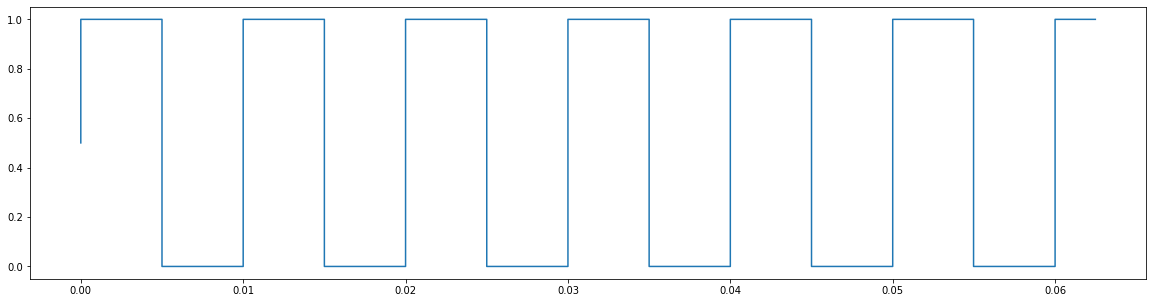

In [ ]:
Fs = 48000
time = np.arange(0, 10, 1/Fs)
f = 100
y = np.sin(2*np.pi*f*time)
square = (np.sign(y)+1)/2
plt.figure(figsize=(20,5));
plt.step(time[0:3000],square[0:3000]);

In [ ]:
# Guardamos el wav
#scipy.io.wavfile.write("square_wave100hz.wav", Fs, square)

### Generamos el barrido lineal en frecuencia
Comienzo: 20Hz

Final: 20KHz

T: 1

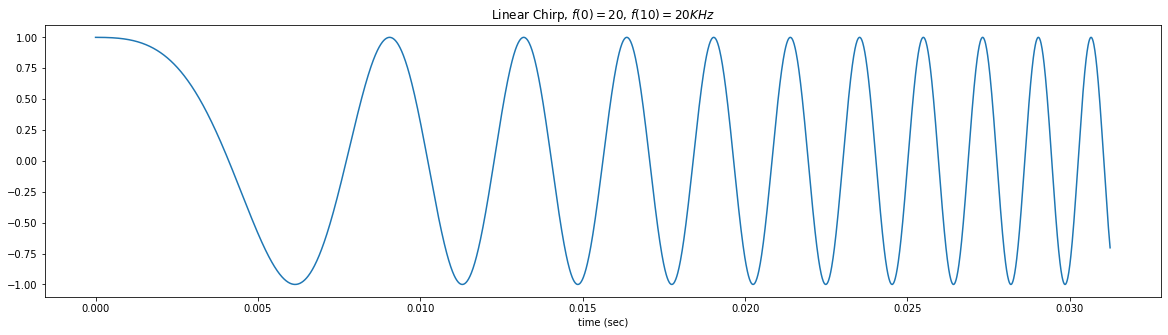

In [ ]:
time_chirp = np.arange(0, 1, 1/(2*Fs))
chirp = signal.chirp(time_chirp, f0=20, f1=20e3, t1=1, method='linear')
plt.figure(figsize=(20,5));
plt.plot(time_chirp[0:3000], chirp[0:3000]);
plt.title("Linear Chirp, $f(0)=20$, $f(10)=20KHz$");
plt.xlabel('time (sec)');

In [ ]:
# Guardamos el wav
#scipy.io.wavfile.write("linsweep20to20e3.wav", Fs, chirp)

### Generamos el barrido exponencial en frecuencia
Comienzo: 20Hz

Final: 20KHz

T: 1




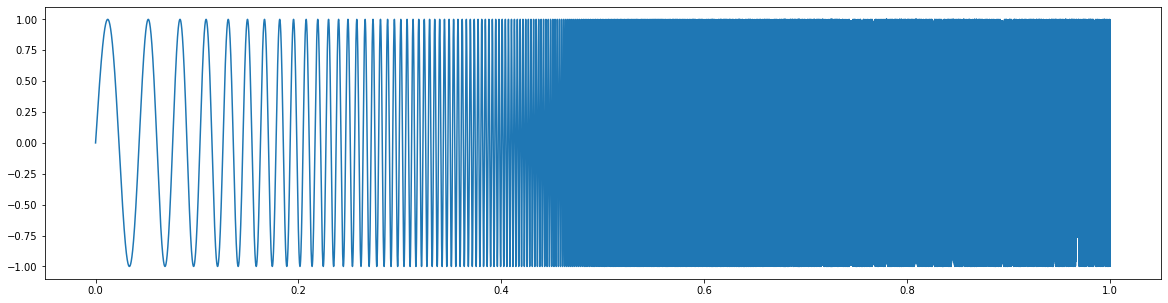

In [ ]:
T = 1
time_chirp = np.arange(0, T, 1/(Fs))
k = (20e3/20)**T
u = np.sin(2*np.pi*20*(k**time_chirp-1)/np.log(k))
plt.figure(figsize=(20,5));
plt.plot(time_chirp, u)

In [ ]:
# Guardamos el wav
#scipy.io.wavfile.write("expsweep20to20e3.wav", Fs, u)

### Señal de ruido blanco gaussiano


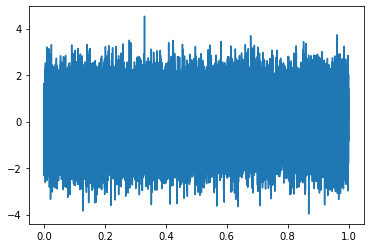

In [ ]:
# time = np.arange(0, T, 1/(Fs))
# awgn = np.random.randn(len(time))
# awgn = awgn
# plt.figure(figsize=(20,5));
# plt.plot(time, awgn);

In [ ]:
# Guardamos el wav
#scipy.io.wavfile.write("awgn.wav", Fs, awgn)

# Preprocesamiento

In [65]:
root_r = PurePath('/content/drive/Shared drives/PASA/TP 2/Grabaciones/Audacity')
root_o = PurePath('/content/drive/Shared drives/PASA/TP 2/Originales')
recordings = ["r_boh", "r_square", "r_sweep","r_voz","r_exp","r_white"]
originals = ["o_boh", "o_square", "o_sweep","o_voz","o_exp","o_white"]
cut_recordings_names = ["rc_boh", "rc_square", "rc_sweep","rc_voz","rc_exp","rc_white"]
cut_originals_names = ["oc_boh", "oc_square", "oc_sweep","oc_voz","oc_exp","oc_white"]

In [66]:
def allign(input_sig, received_sig):
  received_sig = np.concatenate((np.zeros(10000),received_sig))
  maxlen = np.minimum(len(input_sig), len(received_sig))
  if len(received_sig) >  len(input_sig):
    input_sig = np.concatenate((input_sig,np.zeros(len(received_sig)- len(input_sig))))
  else:
    raise ValueError(f"La longitud de received_sig no es mayor que input_sig!!!")
  
  cross_corr = signal.correlate(input_sig, received_sig)
  middle = len(cross_corr)//2
  max = np.argmax(np.abs(cross_corr))
  difference = middle - max
  if difference >= 0:
    received_sig = received_sig[difference: difference+maxlen]
    input_sig = input_sig[0:len(received_sig)]
  else:
    difference = np.abs(difference)
    input_sig = input_sig[difference:difference+maxlen]
    received_sig = received_sig[0: len(input_sig)]
  return input_sig, received_sig

# t = np.linspace(0,0.05,100000)
# input = np.sin(2*np.pi * 1000 *t)
# input2 = np.concatenate((input,np.zeros(1000)))
# received = np.concatenate((input,np.zeros(1000)))
# plt.plot(input2)
# plt.plot(received)
# a,b = allign(input2,received)
# c = a-b
# plt.plot(c)

In [67]:
cut_recordings = {}
cut_originals = {}
duration = 1
Fs = 48000

for recording, original, crn, con, in zip(recordings, originals, cut_recordings_names, cut_originals_names):
  path_r = root_r.joinpath(recording)
  path_r = path_r.with_suffix(".wav")
  path_o = root_o.joinpath(original)
  path_o = path_o.with_suffix(".wav")
  fs, r_waveform = scipy.io.wavfile.read(path_r);
  fs, o_waveform = scipy.io.wavfile.read(path_o);

  # temp = o_waveform
  # o_waveform = np.concatenate((o_waveform,np.zeros(len(r_waveform)-len(o_waveform))))
  # correlation = signal.correlate(o_waveform, r_waveform)
  # lag_exp = 2000  ## Para asegurar que se cumpla el principio de causalidad
  # index = len(correlation)//2 + 1 -np.argmax(np.abs(correlation)) - lag_exp
  # inicio = 0
  # longi = 48000
  temp_o, temp_r = allign(o_waveform,r_waveform)
  
  #Normalizamos
  #temp_o = temp[inicio:inicio+longi]
  temp_o = temp_o - np.mean(temp_o)
  cut_originals[con] =  temp_o / np.max(np.abs(temp_o))
  #temp_r = r_waveform[index+inicio:index+inicio+longi]
  temp_r = temp_r - np.mean(temp_r)
  cut_recordings[crn] = temp_r / np.max(np.abs(temp_r)) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: WavFileWarning: Chunk (non-data) not understood, skipping it.
  if sys.path[0] == '':


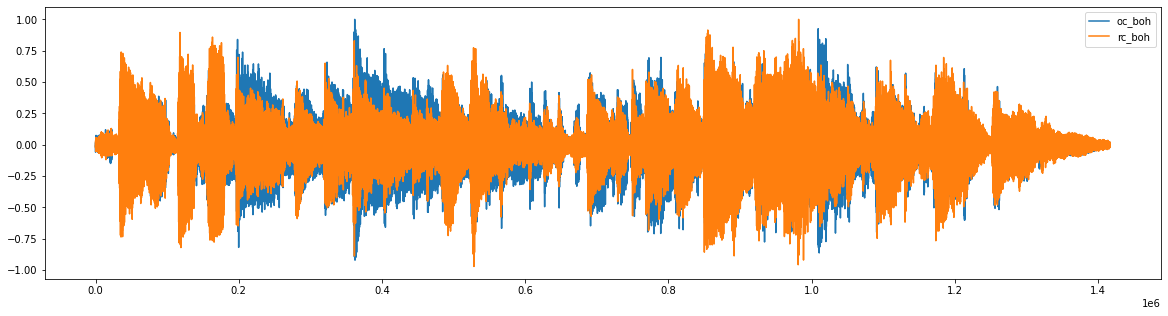

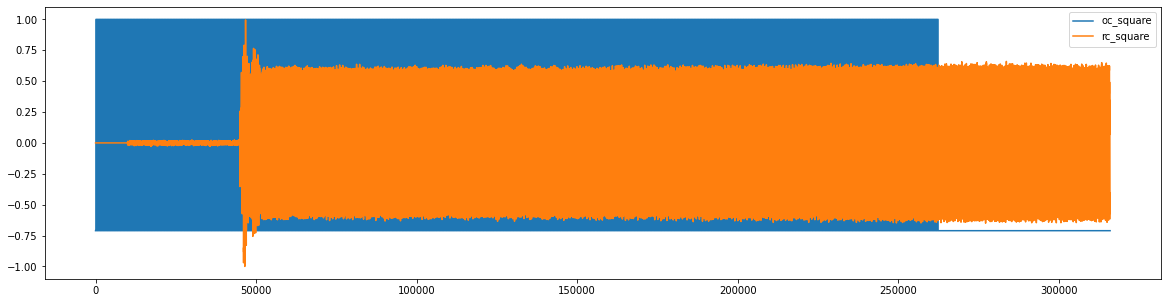

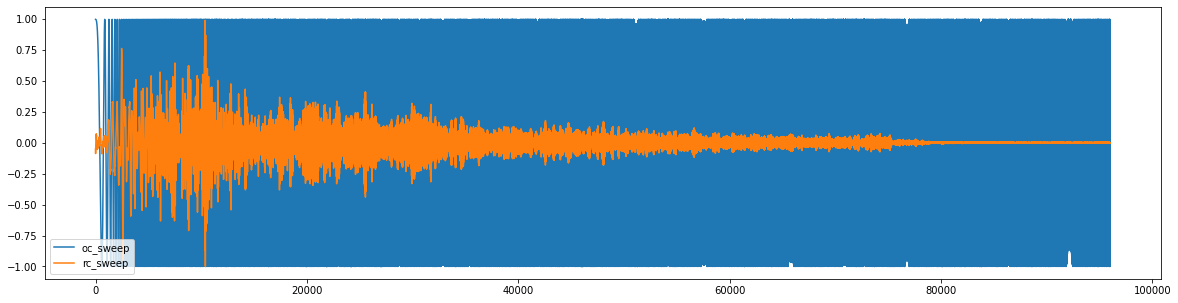

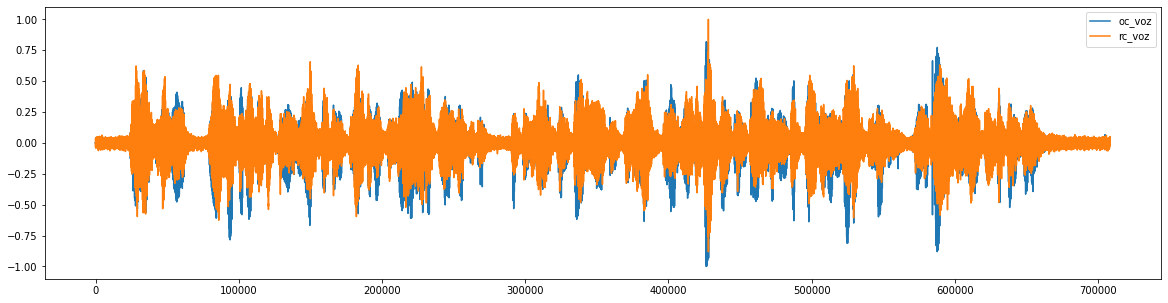

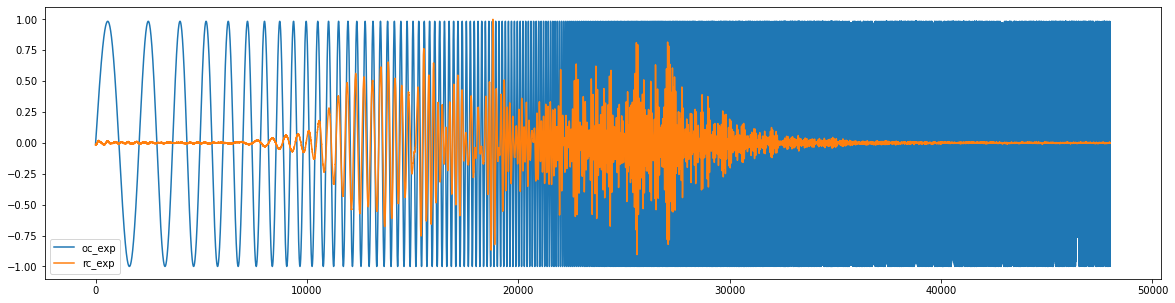

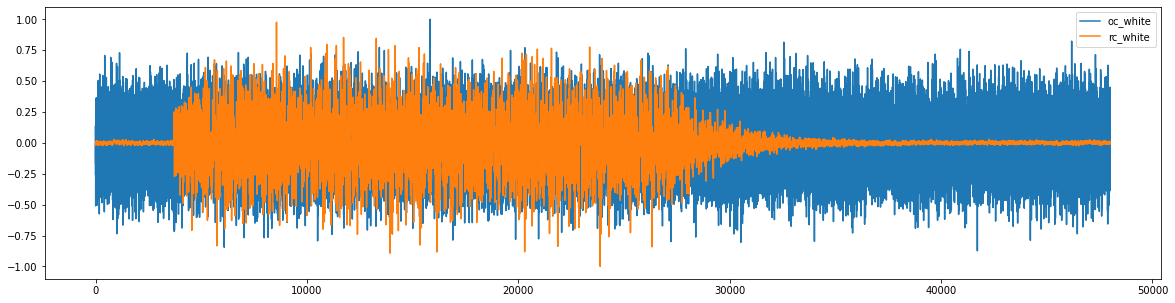

In [68]:
for oc_name, rc_name in zip(cut_originals_names, cut_recordings_names):
  plt.figure(figsize=(20,5))
  plt.plot(cut_originals[oc_name], label=oc_name)
  plt.plot(cut_recordings[rc_name], label=rc_name)
  plt.legend()

# Calculo de las matrices $R$ de autocorrelación
Tenemos la ecuación de Wiener-Hopf
$$R \ \omega_o = p$$
de la cual podemos despejar $\omega_o$ obteniendo
$$\omega_o = R^{-1}p$$

In [128]:
from scipy.linalg import toeplitz
def estimate(u, d):
#esta funcion no devuelve la matriz de autocorrelación R porque es de tamaño len(u), y consumiría aprox más de 666 GB de memoria
  u_fft = np.fft.fft(u)
  d_fft = np.fft.fft(d)
  r = np.fft.ifft(u_fft * u_fft.conj()).real
  r = r[:len(u)//2]/len(u)
  p = np.fft.ifft(u_fft * d_fft.conj()).real
  p = p[len(u)//2:]/len(u)
  p = np.flip(p)
  sigma2d = np.var(d)
  return r, p, sigma2d

def do_wh(input, desired, M=15):
  auto_corr = signal.correlate(input, input)/len(input)
  middle = len(auto_corr)//2
  topmat = toeplitz(auto_corr[middle:middle+M])
  cross_corr = signal.correlate(input, desired)/len(input)
  middle_cc = len(cross_corr)//2
  p = cross_corr[-M+1+middle_cc:middle_cc+1]
  p = cross_corr[middle_cc:middle_cc+M]
  p = np.flip(p);
  wo = np.matmul(np.linalg.inv(topmat), p)
  # r, p, sigma2d = estimate(input,desired)
  # R = toeplitz(auto_corr[0:M])
  #print(R)
  # wo = np.dot(np.linalg.inv(R), p[0:M])
  return wo, p

def filter_new(input, coef):
  # out = []
  # for i in range(len(input)):
  #   temp = 0
  #   rang = np.minimum(i+1,len(coefs))
  #   for u in range(rang):
  #     temp += coefs[u]*input[i-u]
  #   out.append(temp)
  # return signal.convolve(input, coef, mode="same")
  return signal.filtfilt(coef,[1],input)
  #return out

In [148]:
jtas = []
wos = []
for i in tqdm(range(5,5000,100)):
  # for oc_name, rc_name in zip(cut_originals_names, cut_recordings_names):
  sigma2d = np.var(cut_recordings["rc_square"])

  wo, p = do_wh(cut_recordings["rc_square"],cut_originals["oc_square"], M=i)
  wos.append(wo)
  # filtered_signal = filter_new(cut_originals[oc_name],wo)
  # filtered_signal = filtered_signal#/np.max(np.abs(filtered_signal))
  # e_n = cut_recordings[rc_name][0:len(filtered_signal)] - filtered_signal
  # J = np.mean(e_n**2)
  sigma2dhat = np.dot(p,wo)
  J = sigma2d-sigma2dhat 
  jtas.append(J)
  #print(f"J calculado para {oc_name} con M:{i} = {J}")
  # break
print(np.argmax(jtas))



0


49


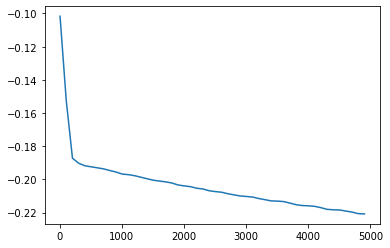

In [151]:
print(np.argmin(jtas))
plt.plot(range(5,5000,100),jtas)

In [152]:
filtered_song  = filter_new(cut_originals["oc_square"], wos[49])
# filtered_song = filtered_song/np.max(np.abs(filtered_song))
# a, b = allign(cut_originals["oc_boh"], filtered_song)

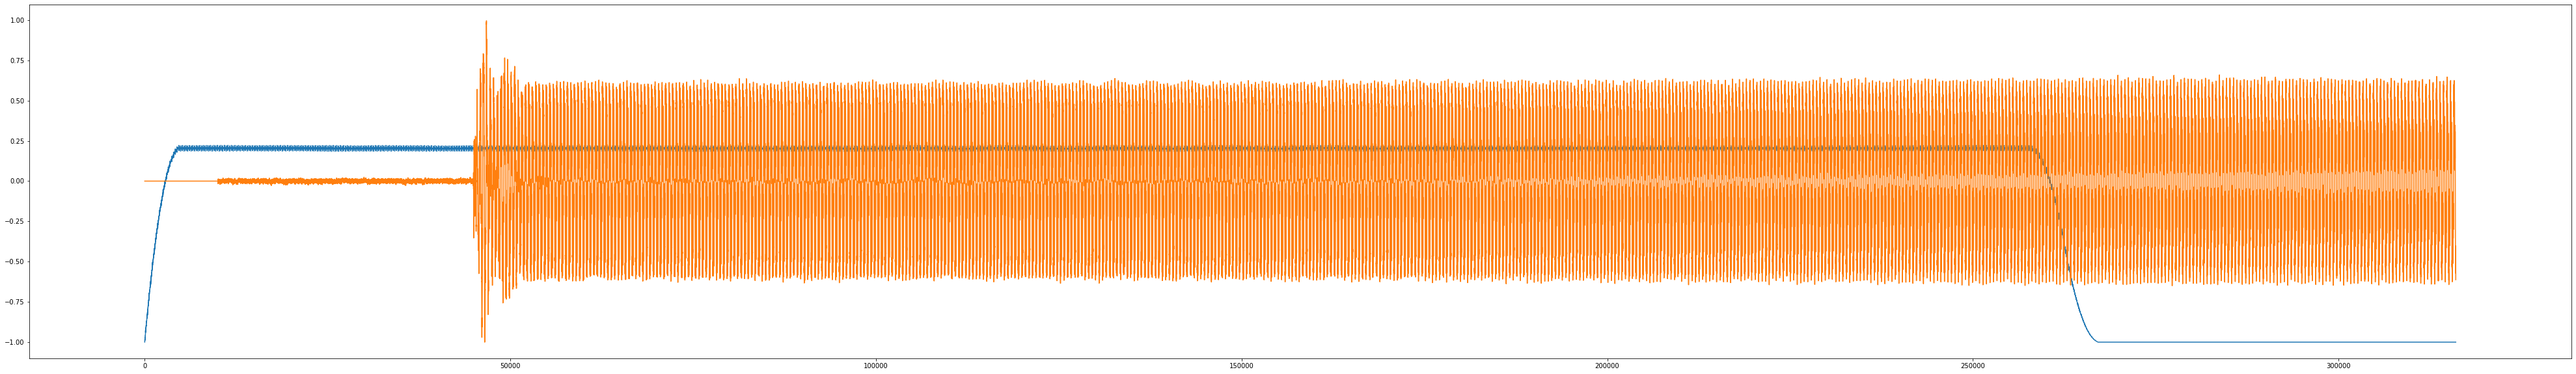

In [155]:
plt.figure(figsize=(70,10))
plt.plot(filtered_song/np.max(np.abs(filtered_song)))
# plt.plot(filtered_song)
plt.plot(cut_recordings["rc_square"])
# plt.plot(a-b)

In [133]:
import scipy.io.wavfile
scipy.io.wavfile.write("prueba49nni.wav",48000,filtered_song)

In [ ]:
plt.figure(figsize=(40,10))
# plt.plot(cut_recordings[rc_name][33500:34000])
# plt.plot(filtered_signal[33500:34000])
# plt.plot(e_n[33500:34000])
plt.plot(cut_recordings[rc_name][0:len(filtered_signal)])
plt.plot(filtered_signal)
plt.plot(e_n)
plt.grid(axis= "both")

In [ ]:
plt.figure(figsize=(40,10))
plt.plot(cut_originals[oc_name][32500:] * 3)
plt.plot(cut_recordings[rc_name][32500:])
plt.plot(filtered_signal[32500:]*0.5)

In [ ]:
a,b = allign(filtered_signal,cut_recordings[rc_name])
a = a/(np.max(a))
b = b/(np.max(b)) 
c = a-b

plt.figure(figsize=(40,10))
plt.plot(a[33500:34000])
plt.plot(b[33500:34000])
plt.plot(c[33500:34000])
plt.grid(axis="both")


In [ ]:
t = np.linspace(0,0.05,100000)
input = np.sin(2*np.pi * 1000 *t)
inp = [1,2,3]
coefs = [2, 1]
out = filter(inp, coefs)
#wo = do_wh(out,input, M=4)
print(out)

[2 5 8]
